# "Cross-validation" des modèles

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Hyper-parametres
learning_rate = 0.04
num_epochs = 400
N = 100
N_cv = 40
seed = 42
batch_size = N//4
#batch_size = N//2
N_test = 0
N_test = 1000
N_scan = 9
bias = True


p0 = 0.05 #lapse rate
theta0 = 0
wt = np.pi/20
theta_std = np.pi/6



## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed=seed):
    np.random.seed(42)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p #add lapse rate
    y = np.random.rand(N) < p #generate data
    return theta, p, y

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2): #-2 ?
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))

    def forward(self, theta):
        out = self.logit0.sigmoid()/2 + (1-self.logit0.sigmoid())*self.linear(theta).sigmoid()
        return out
        

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                batch_size = batch_size,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader))
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    return logistic_model, np.mean(losses)

In [5]:
torch.sigmoid(torch.tensor([-3.]))

tensor([0.0474])

In [6]:
%%timeit
theta, p, y = get_data()

41.6 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y,verbose=True) 

Iteration: 0 - Loss: 0.66405
Iteration: 12 - Loss: 0.57675
Iteration: 24 - Loss: 0.52456
Iteration: 36 - Loss: 0.49483
Iteration: 48 - Loss: 0.47570
Iteration: 60 - Loss: 0.46252
Iteration: 72 - Loss: 0.45294
Iteration: 84 - Loss: 0.44590
Iteration: 96 - Loss: 0.44064
Iteration: 108 - Loss: 0.43672
Iteration: 120 - Loss: 0.43382
Iteration: 132 - Loss: 0.43161
Iteration: 144 - Loss: 0.42985
Iteration: 156 - Loss: 0.42874
Iteration: 168 - Loss: 0.42770
Iteration: 180 - Loss: 0.42687
Iteration: 192 - Loss: 0.42631
Iteration: 204 - Loss: 0.42584
Iteration: 216 - Loss: 0.42555
Iteration: 228 - Loss: 0.42529
Iteration: 240 - Loss: 0.42512
Iteration: 252 - Loss: 0.42495
Iteration: 264 - Loss: 0.42486
Iteration: 276 - Loss: 0.42497
Iteration: 288 - Loss: 0.42480
Iteration: 300 - Loss: 0.42476
Iteration: 312 - Loss: 0.42472
Iteration: 324 - Loss: 0.42464
Iteration: 336 - Loss: 0.42463
Iteration: 348 - Loss: 0.42459
Iteration: 360 - Loss: 0.42456
Iteration: 372 - Loss: 0.42456
Iteration: 384 - L

In [8]:
with torch.no_grad():
    if bias: print('bias', logistic_model.linear.bias.item())
    print('slope', logistic_model.linear.weight.item())    
    print('p0', torch.sigmoid(logistic_model.logit0).item())


bias 0.0188949599752344
slope 4.9888273553720675
p0 0.0023851509797954205


loss= 0.424514373793


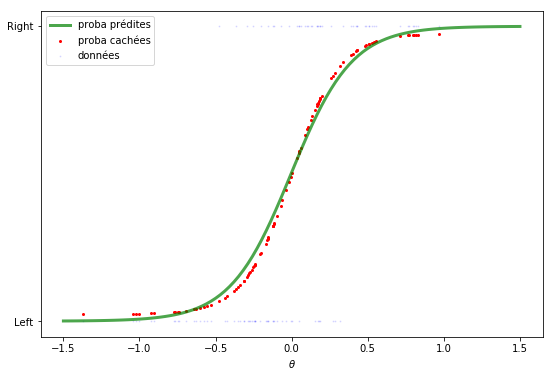

In [9]:
print('loss=', loss)
plt.figure(figsize = (9,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


In [10]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

2.33 s ± 154 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## validation

loss= tensor(0.4245, grad_fn=<BinaryCrossEntropyBackward>)


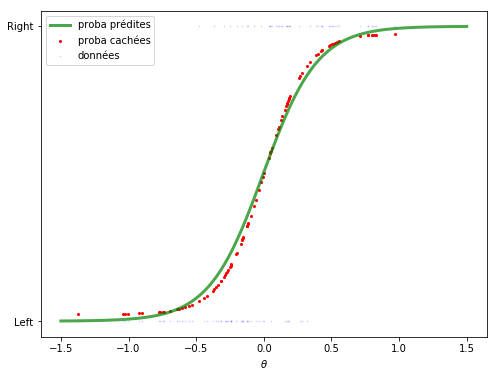

In [11]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [12]:
Ns = np.logspace(1, 3, N_scan, base=10)

Ns_, losses, loss_Ps, loss_P0s = [], [], [], []

for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
    
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        loss_P0s.append(loss_P0)
        Ns_.append(N_)
        loss_Ps.append(loss_P)
        losses.append(loss)
    

N: 10, Loss: 0.49620, loss_P: 0.48876, loss_P0: 0.38791
N: 17, Loss: 0.44237, loss_P: 0.43806, loss_P0: 0.38791
N: 31, Loss: 0.39033, loss_P: 0.39599, loss_P0: 0.38791
N: 56, Loss: 0.38404, loss_P: 0.39262, loss_P0: 0.38791
N: 100, Loss: 0.38543, loss_P: 0.39183, loss_P0: 0.38791
N: 177, Loss: 0.38907, loss_P: 0.39309, loss_P0: 0.38791
N: 316, Loss: 0.38568, loss_P: 0.38901, loss_P0: 0.38791
N: 562, Loss: 0.38226, loss_P: 0.38875, loss_P0: 0.38791
N: 1000, Loss: 0.38230, loss_P: 0.39024, loss_P0: 0.38791


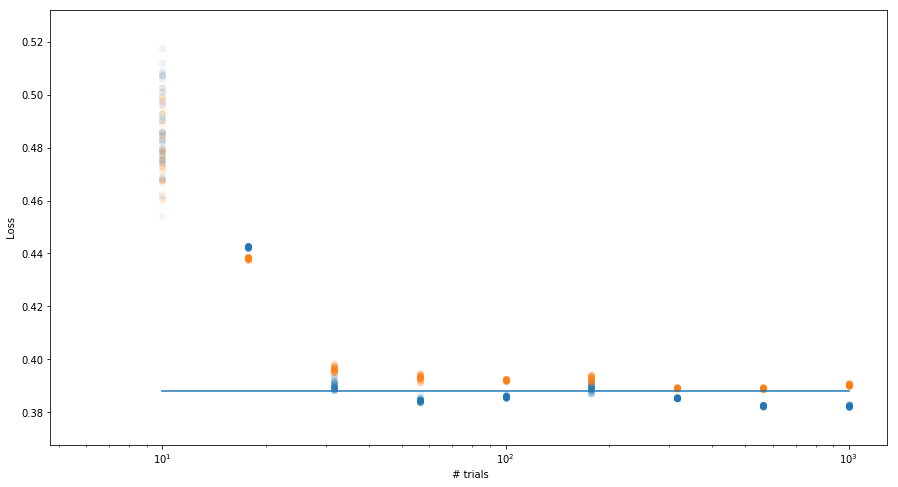

In [13]:
#plot

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(Ns_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du learning rate


In [15]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps, loss_P0s = [], [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        learning_rates_.append(learning_rate_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

learning_rate: 0.00400, Loss: 0.54141, loss_P: 0.54406, loss_P0: 0.38791
learning_rate: 0.00711, Loss: 0.52361, loss_P: 0.52632, loss_P0: 0.38791
learning_rate: 0.01265, Loss: 0.43144, loss_P: 0.43552, loss_P0: 0.38791
learning_rate: 0.02249, Loss: 0.39536, loss_P: 0.40072, loss_P0: 0.38791
learning_rate: 0.04000, Loss: 0.38607, loss_P: 0.39215, loss_P0: 0.38791
learning_rate: 0.07113, Loss: 0.38544, loss_P: 0.39207, loss_P0: 0.38791
learning_rate: 0.12649, Loss: 0.38559, loss_P: 0.39219, loss_P0: 0.38791
learning_rate: 0.22494, Loss: 0.38511, loss_P: 0.39218, loss_P0: 0.38791
learning_rate: 0.40000, Loss: 0.38564, loss_P: 0.39239, loss_P0: 0.38791


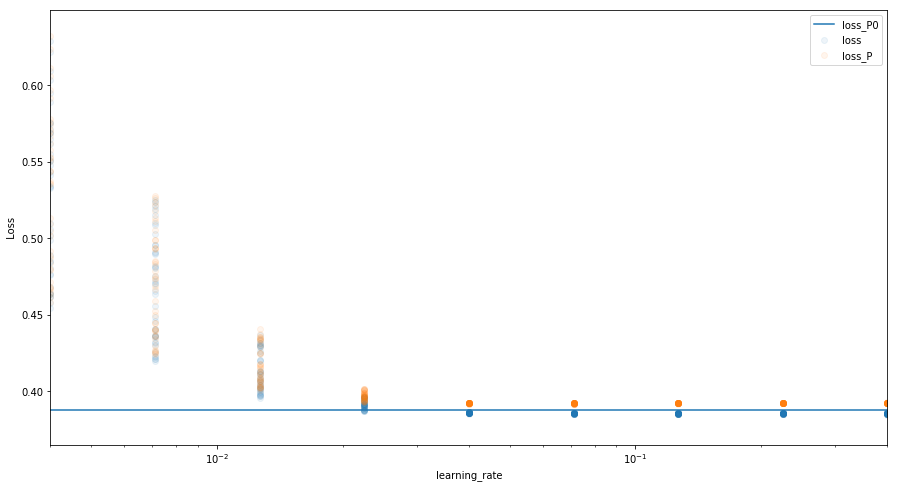

In [16]:
#influence du learning rate sur loss

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(learning_rates_, loss_P0s, label='loss_P0')
ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence du nombre d'epochs

In [17]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_P0s = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        num_epochss_.append(num_epochs_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

num_epochs: 40, Loss: 0.46085, loss_P: 0.46407, loss_P0: 0.38791
num_epochs: 71, Loss: 0.44130, loss_P: 0.44507, loss_P0: 0.38791
num_epochs: 126, Loss: 0.40881, loss_P: 0.41352, loss_P0: 0.38791
num_epochs: 224, Loss: 0.38988, loss_P: 0.39569, loss_P0: 0.38791
num_epochs: 400, Loss: 0.38640, loss_P: 0.39259, loss_P0: 0.38791
num_epochs: 711, Loss: 0.38540, loss_P: 0.39206, loss_P0: 0.38791
num_epochs: 1264, Loss: 0.38557, loss_P: 0.39229, loss_P0: 0.38791
num_epochs: 2249, Loss: 0.38559, loss_P: 0.39237, loss_P0: 0.38791
num_epochs: 4000, Loss: 0.38558, loss_P: 0.39238, loss_P0: 0.38791


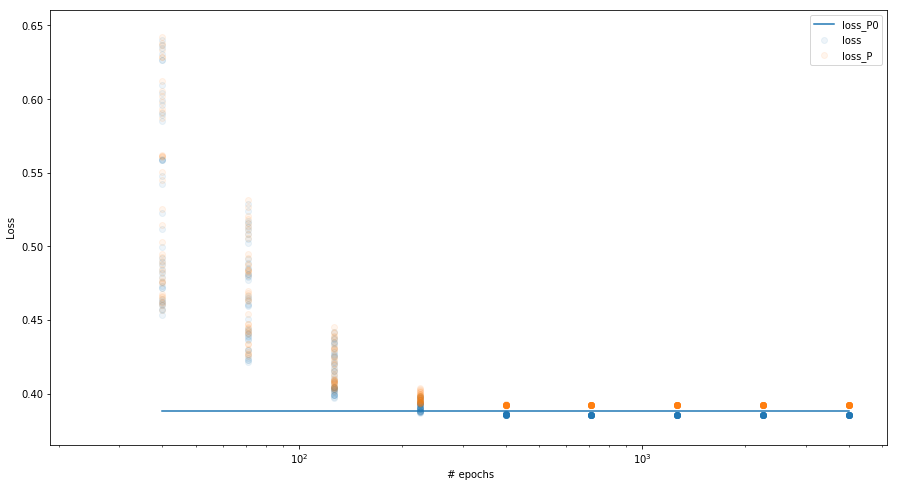

In [18]:
# influence du nbr d'epochs sur loss 
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(num_epochss_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # epochs')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence de la taille du minibatch

In [19]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps, loss_P0s = [], [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        batch_sizes_.append(batch_size_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

batch_size: 12, Loss: 0.38644, loss_P: 0.39235, loss_P0: 0.38791
batch_size: 16, Loss: 0.38554, loss_P: 0.39187, loss_P0: 0.38791
batch_size: 21, Loss: 0.38549, loss_P: 0.39204, loss_P0: 0.38791
batch_size: 27, Loss: 0.38586, loss_P: 0.39210, loss_P0: 0.38791
batch_size: 35, Loss: 0.38568, loss_P: 0.39218, loss_P0: 0.38791
batch_size: 45, Loss: 0.38638, loss_P: 0.39242, loss_P0: 0.38791
batch_size: 59, Loss: 0.38542, loss_P: 0.39201, loss_P0: 0.38791
batch_size: 77, Loss: 0.38477, loss_P: 0.39222, loss_P0: 0.38791
batch_size: 100, Loss: 0.38577, loss_P: 0.39223, loss_P0: 0.38791


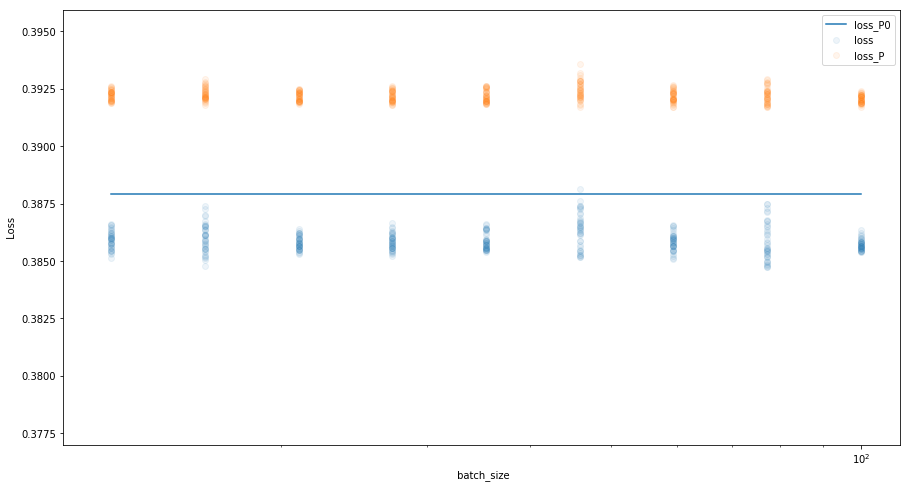

In [20]:
# influence de la taille du minibatch sur loss 

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(batch_sizes_, losses, alpha=3/N_cv, label='loss')
ax.scatter(batch_sizes_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(batch_sizes_, loss_P0s, label='loss_P0')

ax.set_xlabel(' batch_size')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## Comparaison données générées/données prédites

### Tentative I

In [39]:
# p0 prediction/generate I

p0s = np.linspace(0,1,50)
p0_s = []


for p0_ in p0s:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)

    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
    p0_pred =  torch.sigmoid(logistic_model.logit0).item()     
        
    p0_s.append( p0_pred)
    print(f"p0 : {p0_pred: .5f}")



p0 :  0.01880
p0 :  0.01034
p0 :  0.00663
p0 :  0.01712
p0 :  0.01574
p0 :  0.01664
p0 :  0.00889
p0 :  0.01801
p0 :  0.01611
p0 :  0.01056
p0 :  0.01296
p0 :  0.01761
p0 :  0.01528
p0 :  0.01197
p0 :  0.01879
p0 :  0.01258
p0 :  0.00718
p0 :  0.00812
p0 :  0.00962
p0 :  0.01325
p0 :  0.01542
p0 :  0.01341
p0 :  0.01189
p0 :  0.00949
p0 :  0.01354
p0 :  0.01744
p0 :  0.01792
p0 :  0.01656
p0 :  0.01299
p0 :  0.01266
p0 :  0.01368
p0 :  0.00824
p0 :  0.00990
p0 :  0.01716
p0 :  0.01279
p0 :  0.00903
p0 :  0.01124
p0 :  0.01884
p0 :  0.00746
p0 :  0.01085
p0 :  0.00923
p0 :  0.01720
p0 :  0.00740
p0 :  0.01435
p0 :  0.01000
p0 :  0.00851
p0 :  0.01353
p0 :  0.01532
p0 :  0.01357
p0 :  0.01647


Text(0,0.5,'p0 prédit')

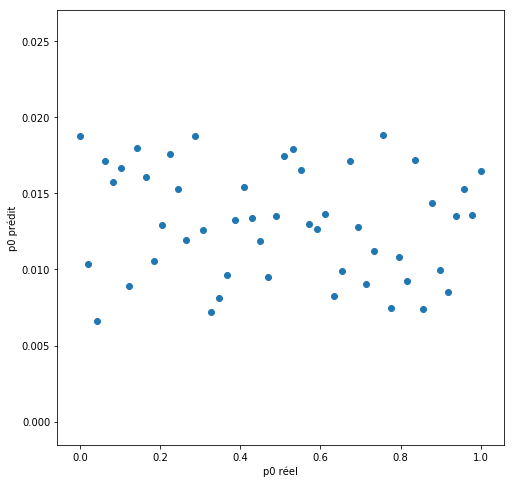

In [43]:
plt.figure(figsize = (8,8)) 
plt.scatter(p0s, p0_s)
plt.xlabel('p0 réel')
plt.ylabel('p0 prédit')


In [47]:
#theta0 prediction/generate 

theta0s = np.random.randn(50)
theta0_s = []

for theta0_ in theta0s:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)

    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        
    theta0_pred = logistic_model.linear.bias.item()
    theta0_s.append(theta0_pred)
        
    print(f" theta0: {theta0_pred:.5f}")
    

 theta0: -0.12868
 theta0: -0.12328
 theta0: -0.11847
 theta0: -0.11808
 theta0: -0.11400
 theta0: -0.11612
 theta0: -0.11655
 theta0: -0.12516
 theta0: -0.12017
 theta0: -0.13014
 theta0: -0.11267
 theta0: -0.11481
 theta0: -0.11659
 theta0: -0.11510
 theta0: -0.11946
 theta0: -0.11848
 theta0: -0.12104
 theta0: -0.12339
 theta0: -0.12976
 theta0: -0.11382
 theta0: -0.11244
 theta0: -0.12124
 theta0: -0.11293
 theta0: -0.12198
 theta0: -0.11570
 theta0: -0.12658
 theta0: -0.11594
 theta0: -0.11348
 theta0: -0.11769
 theta0: -0.11618
 theta0: -0.11354
 theta0: -0.11605
 theta0: -0.11678
 theta0: -0.12970
 theta0: -0.11922
 theta0: -0.11890
 theta0: -0.11926
 theta0: -0.11059
 theta0: -0.11787
 theta0: -0.11943
 theta0: -0.12134
 theta0: -0.11935
 theta0: -0.12427
 theta0: -0.11646
 theta0: -0.12509
 theta0: -0.12402
 theta0: -0.11766
 theta0: -0.11453
 theta0: -0.11802
 theta0: -0.12005


Text(0,0.5,'theta prédit')

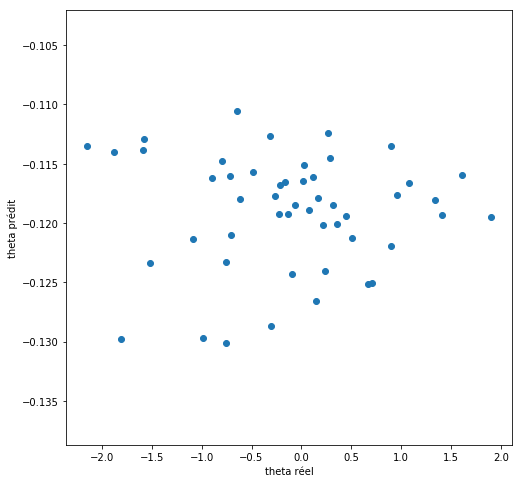

In [48]:
plt.figure(figsize = (8,8)) 
plt.scatter(theta0s, theta0_s)
plt.xlabel('theta réel')
plt.ylabel('theta prédit')


In [53]:
#wt prediction/generate 

wts = np.logspace(-1, 0.1, 50, base=10)
wt_s = []

for wt_ in wts:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)
        
    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        
    wt_pred = logistic_model.linear.weight.item()
        
    wt_s.append(wt_pred)
    print(f" wt:{wt_pred:.5f}")    

 wt:5.55953
 wt:5.57331
 wt:5.64128
 wt:5.60573
 wt:5.58638
 wt:5.66405
 wt:5.58126
 wt:5.66627
 wt:5.57465
 wt:5.61897
 wt:5.58363
 wt:5.74294
 wt:5.57972
 wt:5.57455
 wt:5.62584
 wt:5.54258
 wt:5.48932
 wt:5.58752
 wt:5.61296
 wt:5.68046
 wt:5.68727
 wt:5.52984
 wt:5.73977
 wt:5.51244
 wt:5.69384
 wt:5.49692
 wt:5.62801
 wt:5.57190
 wt:5.51937
 wt:5.61063
 wt:5.58271
 wt:5.65616
 wt:5.62318
 wt:5.64959
 wt:5.56383
 wt:5.65339
 wt:5.70816
 wt:5.48842
 wt:5.63687
 wt:5.62317
 wt:5.73448
 wt:5.54839
 wt:5.52783
 wt:5.57809
 wt:5.62866
 wt:5.52070
 wt:5.50384
 wt:5.47684
 wt:5.70217
 wt:5.50164


Text(0,0.5,'pente prédite')

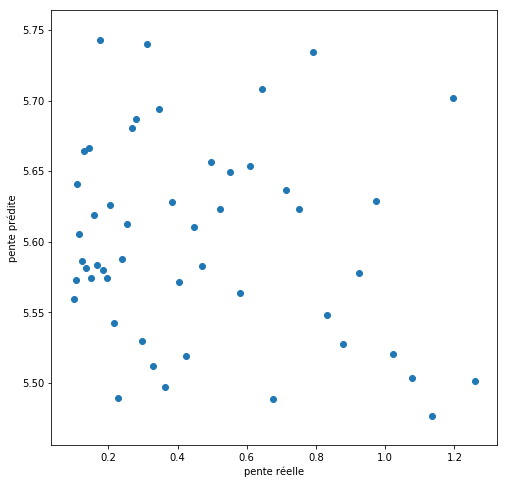

In [54]:
plt.figure(figsize = (8,8)) 
plt.scatter(wts, wt_s)
plt.xlabel('pente réelle')
plt.ylabel('pente prédite')


### Tentative II

p0 :  0.01642
p0 :  0.01217
p0 :  0.01091
p0 :  0.01197
p0 :  0.01132
p0 :  0.00837
p0 :  0.00949
p0 :  0.01299
p0 :  0.01026
p0 :  0.01328
p0 :  0.00842
p0 :  0.00814
p0 :  0.01052
p0 :  0.01173
p0 :  0.01303
p0 :  0.00781
p0 :  0.01114
p0 :  0.01803
p0 :  0.01922
p0 :  0.00677
p0 :  0.00725
p0 :  0.01648
p0 :  0.01128
p0 :  0.01128
p0 :  0.00827
p0 :  0.00999
p0 :  0.01546
p0 :  0.00890
p0 :  0.01585
p0 :  0.01435
p0 :  0.01204
p0 :  0.01154
p0 :  0.01035
p0 :  0.01572
p0 :  0.01934
p0 :  0.01187
p0 :  0.01617
p0 :  0.01479
p0 :  0.01013
p0 :  0.01537
p0 :  0.01553
p0 :  0.00814
p0 :  0.01101
p0 :  0.01092
p0 :  0.00940
p0 :  0.01012
p0 :  0.01281
p0 :  0.01673
p0 :  0.01320
p0 :  0.01030


Text(0,0.5,'p0 prédit')

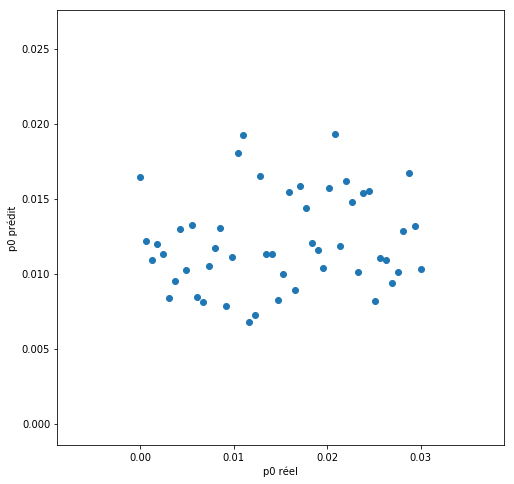

In [78]:
# p0 prediction/generate I

p0s = np.linspace(0,0.03,50)
p0_s = []


for p0_ in p0s:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)

    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
    p0_pred =  torch.sigmoid(logistic_model.logit0).item()     
        
    p0_s.append( p0_pred)
    print(f"p0 : {p0_pred: .5f}")

plt.figure(figsize = (8,8)) 
plt.scatter(p0s, p0_s)
plt.xlabel('p0 réel')
plt.ylabel('p0 prédit')


 theta0: -0.12468
 theta0: -0.11943
 theta0: -0.12253
 theta0: -0.11682
 theta0: -0.11326
 theta0: -0.11437
 theta0: -0.12827
 theta0: -0.12186
 theta0: -0.11555
 theta0: -0.11766
 theta0: -0.12259
 theta0: -0.11419
 theta0: -0.12320
 theta0: -0.12702
 theta0: -0.12923
 theta0: -0.11710
 theta0: -0.11680
 theta0: -0.11721
 theta0: -0.11510
 theta0: -0.11292
 theta0: -0.11772
 theta0: -0.12714
 theta0: -0.12031
 theta0: -0.12056
 theta0: -0.11236
 theta0: -0.12855
 theta0: -0.11871
 theta0: -0.11427
 theta0: -0.11253
 theta0: -0.11646
 theta0: -0.12981
 theta0: -0.13262
 theta0: -0.11575
 theta0: -0.11325
 theta0: -0.12349
 theta0: -0.11734
 theta0: -0.11932
 theta0: -0.11074
 theta0: -0.11225
 theta0: -0.11805
 theta0: -0.11967
 theta0: -0.12082
 theta0: -0.11810
 theta0: -0.12856
 theta0: -0.11922
 theta0: -0.12688
 theta0: -0.11440
 theta0: -0.12063
 theta0: -0.12422
 theta0: -0.11929


Text(0,0.5,'theta prédit')

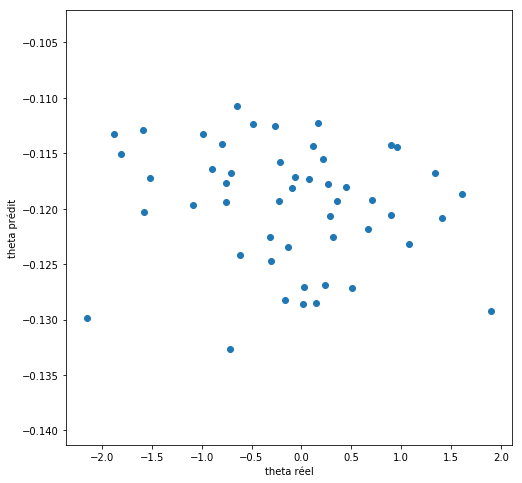

In [80]:
#theta0 prediction/generate 

theta0s = np.random.randn(50) #hum... pas terrible
theta0_s = []

for theta0_ in theta0s:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)

    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        
    theta0_pred = logistic_model.linear.bias.item()
    theta0_s.append(theta0_pred)
        
    print(f" theta0: {theta0_pred:.5f}")
    
plt.figure(figsize = (8,8)) 
plt.scatter(theta0s, theta0_s)
plt.xlabel('theta réel')
plt.ylabel('theta prédit')


 wt:5.65623
 wt:5.70153
 wt:5.66475
 wt:5.57101
 wt:5.59122
 wt:5.65957
 wt:5.60938
 wt:5.60013
 wt:5.72791
 wt:5.57995
 wt:5.51757
 wt:5.76679
 wt:5.77661
 wt:5.66380
 wt:5.63466
 wt:5.53622
 wt:5.60213
 wt:5.55864
 wt:5.60116
 wt:5.56554
 wt:5.51391
 wt:5.73585
 wt:5.68148
 wt:5.60241
 wt:5.69435
 wt:5.58313
 wt:5.73068
 wt:5.72288
 wt:5.50410
 wt:5.72431
 wt:5.56019
 wt:5.55899
 wt:5.58552
 wt:5.54789
 wt:5.66769
 wt:5.59346
 wt:5.53358
 wt:5.66726
 wt:5.51785
 wt:5.66308
 wt:5.62320
 wt:5.63246
 wt:5.65817
 wt:5.49698
 wt:5.73549
 wt:5.56711
 wt:5.66733
 wt:5.56000
 wt:5.76886
 wt:5.52356


Text(0,0.5,'pente prédite')

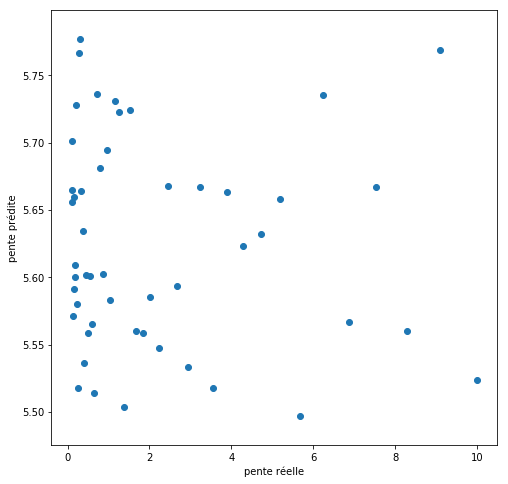

In [81]:
#wt prediction/generate 

wts = np.logspace(-1, 1, 50, base=10)
wt_s = []

for wt_ in wts:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)
        
    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        
    wt_pred = logistic_model.linear.weight.item()
        
    wt_s.append(wt_pred)
    print(f" wt:{wt_pred:.5f}") 
    
plt.figure(figsize = (8,8)) 
plt.scatter(wts, wt_s)
plt.xlabel('pente réelle')
plt.ylabel('pente prédite')
